In [2]:
import pymaltspro as pmp
import pymalts as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import wasserstein_trees as wstree

# Synthetic dataset -- MALTS

# Synthetic Dataset - MALTSPro

# Synthetic dataset used in Linbo's paper

In [90]:
def sample_from_qtl_fn(X_i, A_i, exp_treatment_prob, error_i, qtl_list):
    y_i = []
    for qtl in qtl_list:
        y_i.append((-exp_treatment_prob + A_i + X_i + error_i) * np.sin(np.pi * qtl)/8 + qtl)
    return y_i
def sample_from_qtl_fn_cf(X_i, A_i, exp_treatment_prob, error_i, qtl_list):
    y_i = []
    for qtl in qtl_list:
        y_i.append((-exp_treatment_prob + (1 - A_i) + X_i + error_i) * np.sin(np.pi * qtl)/8 + qtl)
    return y_i

np.random.seed(100)
n_units = 1000
n_obs_per_unit = 1001
feature_x = np.random.uniform(low = -1, high = 1, size = n_units)
treatment_probs = np.apply_along_axis(arr = feature_x, 
                                axis = 0, 
                                func1d = lambda x: np.exp(x)/(1 + np.exp(x)))
treatment = np.array([np.random.binomial(n = 1, p = i) for i in treatment_probs])
expectation_treatment = np.mean(treatment_probs)
error = np.random.uniform(low = -0.5, high = 0.5, size = n_units)
y_qtls = np.random.uniform(low = 0, high = 1, size = (n_units, n_obs_per_unit))
y_obs = []
y_cf  = []
for i in range(n_units):
    y_obs.append(sample_from_qtl_fn(X_i = feature_x[i],
                       A_i = treatment[i],
                       exp_treatment_prob = expectation_treatment, 
                       error_i = error[i],
                       qtl_list = y_qtls[i, :]))
for i in range(n_units):
    y_cf.append(sample_from_qtl_fn_cf(X_i = feature_x[i],
                       A_i = treatment[i],
                       exp_treatment_prob = expectation_treatment, 
                       error_i = 0, # should be no noise in counterfactual
                       qtl_list = y_qtls[i, :]))
y_obs = np.array(y_obs)
y_cf  = np.array(y_cf)
y_mean = y_obs.mean(axis = 1)
y_cf_mean = y_cf.mean(axis = 1)

In [91]:
malts_data = pd.DataFrame({
    'X' : feature_x,
    'treatment' : treatment,
    'Y' : y_mean
})

In [92]:
# split into training and testing
np.random.seed(1001)
train_test_index = np.random.binomial(n = 1, p = 0.2, size = n_units).astype(bool)
train = malts_data.assign(keep = train_test_index).query('keep == 0').drop('keep', 1)
valid = malts_data.assign(keep = train_test_index).query('keep == 1').drop('keep', 1)
X_train = train.reset_index()
X_valid = valid.reset_index()
X_train = X_train.drop(['index', 'Y'], axis = 1)
X_valid = X_valid.drop(['index', 'Y'], axis = 1)
y_train = y_obs[~train_test_index, :]
y_valid =  y_obs[train_test_index, :]

In [6]:
malts = pm.malts(outcome = 'Y',
                 treatment = 'treatment',
                 data = train,
                 discrete = [],
                 C = 0.1,
                 k = 10,
                 reweight = False)

In [7]:
%%time
malts.fit(method = 'SLSQP')

CPU times: user 893 ms, sys: 137 ms, total: 1.03 s
Wall time: 187 ms


     fun: 0.5325959499489149
     jac: array([2.23517418e-08])
 message: 'Optimization terminated successfully.'
    nfev: 13
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([8.94069521e-08])

In [8]:
malts_mg = malts.get_matched_groups(valid)
malts_cate = malts.CATE(MG = malts_mg)
malts_ate = malts_cate.CATE.mean()

In [10]:
true_ate = ((2 * treatment - 1) * y_mean + (2 * (1 - treatment) - 1) * y_cf_mean).mean()

%%time
###### Turn this chunk into code block if you want to rerun maltspro on linbo's dataset (takes ~1hr to run)
############### # check if it will work for pymaltspro
maltspro = pmp.pymaltspro(X = X_train,
                          y = y_train, 
                          treatment = 'treatment', 
                          discrete = [],
                          C = 0.001,
                          k = 10)

maltspro.fit(method = 'SLSQP')

In [13]:
with open('maltspro_linbo.pkl', 'rb') as f:
    maltspro = pickle.load(f)

In [14]:
# get matched groups
mg_df = maltspro.get_matched_groups(X_estimation=X_valid, Y_estimation= y_valid, k =10)

In [15]:
# impute counterfactuals using barycenter of k nn
y_bary = maltspro.barycenter_imputation(X_estimation=X_valid, Y_estimation= y_valid, MG = mg_df)

In [7]:
import pandas as pd
ite_csv = pd.read_csv('./experiments/cont_features/dataset_3020/ITE.csv')
ite_csv.ITE_true.mean()

0.499707375

In [16]:
# estimate ITE P(A > B | A ~ Y_i(1), B ~ Y_i(0))
ite_estimates = []
ite_true = []
for i in range(y_valid.shape[0]):
    ite_estimates.append(ITE(y_estimation = y_valid[i, :], 
        y_cf = y_bary[i, :], 
        n_mc_samples = 100000, 
        observed_treatment = X_valid.loc[0, 'treatment']))
    ite_true.append(ITE(y_estimation = y_valid[i, :], 
        y_cf = y_cf[i, :], 
        n_mc_samples = 100000, 
        observed_treatment = X_valid.loc[0, 'treatment']))
ite_estimates = np.array(ite_estimates)
ite_true = np.array(ite_true)

In [17]:
# see MAE of ITE estimate compared to the "truth," which is estimate after knowing the true counterfactuals
np.abs(ite_estimates - ite_true).mean()

0.049756032608695655

In [18]:
# estimate barycenter of untreated potential outcome
untreated_bary = []
for i in range(y_valid.shape[0]):
    if X_valid.loc[i, 'treatment'] == 1:
        untreated_bary.append(y_valid[i, :])
    else:
        untreated_bary.append(y_bary[i, :])
untreated_bary = pmp.wasserstein2_barycenter(sample_array_1_through_n = np.array(untreated_bary), 
                                         weights = np.repeat(1/len(untreated_bary), len(untreated_bary)), 
                                         n_samples_min = maltspro.n_samples_min)
untreated_bary_cdf = np.array([untreated_bary, np.linspace(0, 1, untreated_bary.shape[0])])

In [19]:
# estimate the ATE using MALTS
linbo_ate_array = []
for i in range(y_valid.shape[0]):
    linbo_ite_array = linbo_ITE(y_obs = y_valid[i, :], 
              y_cf = y_bary[i, :], 
              reference_distribution = untreated_bary_cdf, 
              observed_treatment =X_valid.loc[i, 'treatment'], 
              y_obs_qtl_id = False
             )
    linbo_ate_array.append(linbo_ite_array[1, :])
linbo_ate_array = np.array(linbo_ate_array).mean(axis = 0)

In [20]:
# the true ATE for Linbo's estimator
linbo_ate_true = np.array([np.sin(np.pi * t)/8 for t in untreated_bary_cdf[0, :]])

In [93]:
# T-learner for wasserstein random forests
wrf_control = wstree.wass_forest(X = X_train.query('treatment == 0'), 
                   y = y_train[X_train.query('treatment == 0').index.values, :],
                   y_quantile_id=False,
                   min_samples_split=None,
                   max_depth=20,
                   depth=None,
                   node_type=None,
                   n_trees=1,
                   seed=999,
                   n_samples_min=None)

wrf_treated = wstree.wass_forest(X = X_train.query('treatment == 1'), 
                   y = y_train[X_train.query('treatment == 1').index.values, :],
                   y_quantile_id=False,
                   min_samples_split=None,
                   max_depth=20,
                   depth=None,
                   node_type=None,
                   n_trees=1,
                   seed=999,
                   n_samples_min=None)

In [94]:
# predict counterfactual using metalearner
def wrf_meta_predict(X_valid, wrf_treated, wrf_control):
    y_pred = []
    for i in range(X_valid.shape[0]):
        if X_valid.loc[i, 'treatment'] == 1:
            y_pred.append(wrf_control.predict(X_valid.loc[i:i, :].assign(treatment = 0))[0, :])
        else:
            y_pred.append(wrf_treated.predict(X_valid.loc[i:i, :].assign(treatment = 1))[0, :])
    y_pred = np.array(y_pred)
    return y_pred
y_wrf_bary = wrf_meta_predict(X_valid, wrf_control=wrf_control, wrf_treated=wrf_treated)

In [97]:
# compute P(A > B) for each individual using metalearner
ite_wrf_estimates = []
for i in range(y_valid.shape[0]):
    ite_wrf_estimates.append(
        ITE(y_estimation = y_valid[i, :], 
        y_cf = y_wrf_bary[i, :],
        n_mc_samples = 100000,
        observed_treatment = X_valid.treatment[i]))
ite_wrf_estimates = np.array(ite_wrf_estimates)

In [99]:
# calculate Linbo's estimand using the metalearner
linbo_ate_wrf_array = []
for i in range(y_valid.shape[0]):
    linbo_ite_wrf_array = linbo_ITE(y_obs = y_valid[i, :], 
              y_cf = y_wrf_bary[i, :], 
              reference_distribution = untreated_bary_cdf, 
              observed_treatment =X_valid.loc[i, 'treatment'], 
              y_obs_qtl_id = False
             )
    linbo_ate_wrf_array.append(linbo_ite_wrf_array[1, :])
linbo_ate_wrf_array = np.array(linbo_ate_wrf_array).mean(axis = 0)

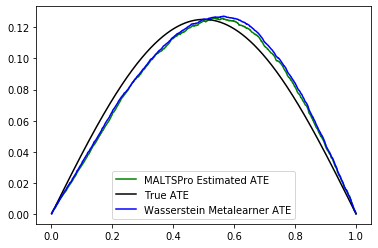

In [101]:
# plot linbo's estimand compared across models
plt.plot(linbo_ite_array[0, :], linbo_ate_array, label = 'MALTSPro Estimated ATE', c = 'green')
plt.plot(linbo_ite_array[0, :], linbo_ate_true, label = 'True ATE', c = 'black')
# plt.legend()
# plt.show()
plt.plot(linbo_ite_array[0, :], linbo_ate_wrf_array, label = 'Wasserstein Metalearner ATE', c = 'blue')
# plt.plot(linbo_ite_array[0, :], linbo_ate_true, label = 'True ATE', c = 'black')
plt.legend()
plt.show()